<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Установка-компонентов" data-toc-modified-id="Установка-компонентов-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Установка компонентов</a></span></li><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Указание-констант" data-toc-modified-id="Указание-констант-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Указание констант</a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Ресемплирование" data-toc-modified-id="Ресемплирование-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Ресемплирование</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Сезонность-и-тренд" data-toc-modified-id="Сезонность-и-тренд-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Сезонность и тренд</a></span></li><li><span><a href="#Скользящее-среднее" data-toc-modified-id="Скользящее-среднее-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Скользящее среднее</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LinearRegressor" data-toc-modified-id="LinearRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LinearRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LGBMRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Цель:** построить модель для предсказания количества заказов на следующий час.

**Задачи:**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

**Описание данных:**

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

### Установка компонентов

In [2]:
%%capture
!pip install phik
!pip install mlxtend
!pip install -U scikit-learn

### Импорт библиотек

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import timeit
import warnings

warnings.filterwarnings("ignore")  

#библиотеки для работы с графиками
import matplotlib.pyplot as plt 
from mlxtend.plotting import plot_decision_regions
from itertools import combinations

#класс для разделения данных на выборки
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
    TimeSeriesSplit,
    RandomizedSearchCV, 
    GridSearchCV
)

#модели
from sklearn.svm import SVC
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

#метрики
from phik.report import plot_correlation_matrix
from phik import phik_matrix
from sklearn.metrics import(
    confusion_matrix, 
    accuracy_score,
    f1_score,
    fbeta_score,
    roc_auc_score,
    ConfusionMatrixDisplay,
    mean_squared_error
)

#классы подготовки данных
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder,
    StandardScaler,
    MinMaxScaler, 
)

# класс для работы с пропусками
from sklearn.impute import SimpleImputer 

#класс для работы с пайплайнами
from sklearn.pipeline import Pipeline

#Для анализа временного ряда
from statsmodels.tsa.seasonal import seasonal_decompose

### Указание констант

In [80]:
TEST_SIZE = 0.1
state = np.random.RandomState(12345)

## Подготовка

True

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


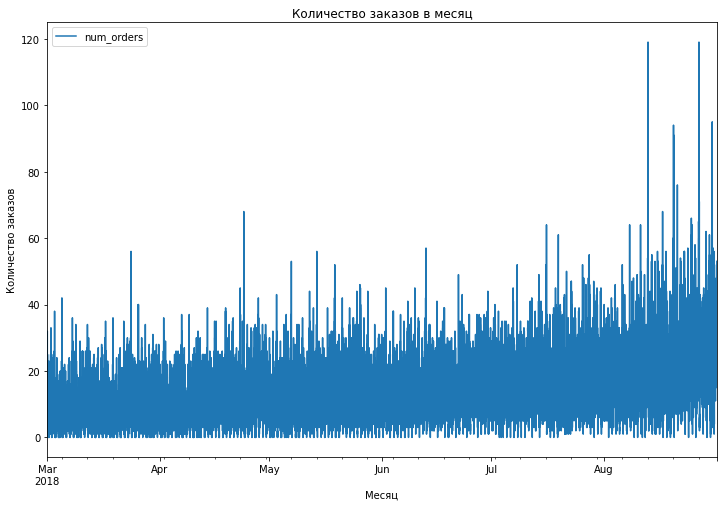

In [81]:
data = pd.read_csv('/datasets/taxi.csv', index_col = [0], parse_dates = [0])
display(data.index.is_monotonic)
display(data.head(15))
data.info()
display(data.describe().T)


data.plot(figsize = (12, 8))
plt.ylabel('Количество заказов')
plt.xlabel('Месяц')
plt.title('Количество заказов в месяц');

- Всего 26496 записей, диапазон дат представлен с марта по конец августа 2018 года. 
- Пропусков нет.

### Ресемплирование

Проведем ресемплирование данных по часу

In [82]:
data = data.resample('1H').sum()
display(data.head())
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


После ресемплирования кличество записей сократилось до 4416.

## Анализ

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


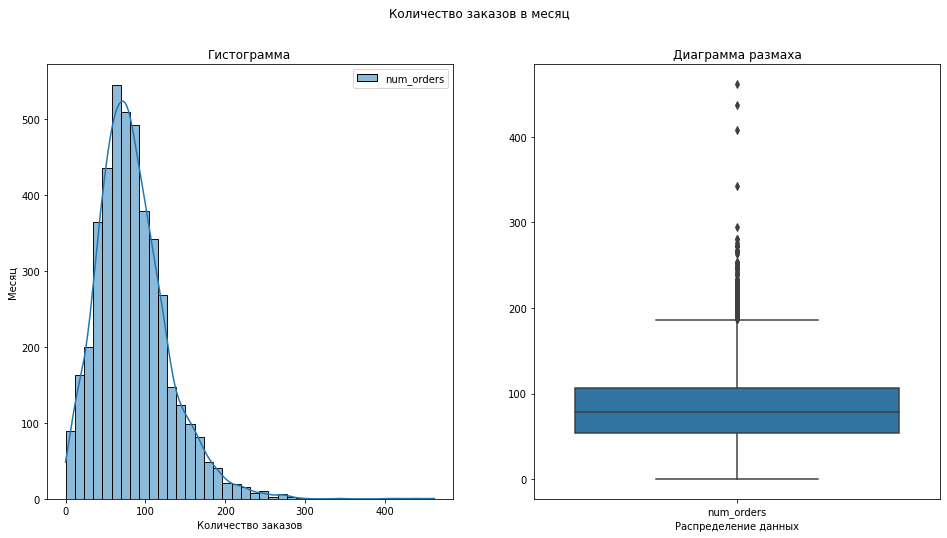

In [83]:
display(data.describe().T)

fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
 
sns.histplot(data = data, ax=axs[0], bins = 40, kde=True)
axs[0].set_xlabel('Количество заказов')
axs[0].set_ylabel('Месяц')
axs[0].set_title('Гистограмма')

sns.boxplot(data = data, ax=axs[1])
axs[1].set_xlabel('Распределение данных')
axs[1].set_title('Диаграмма размаха')
fig.suptitle(f'Количество заказов в месяц');

### Сезонность и тренд

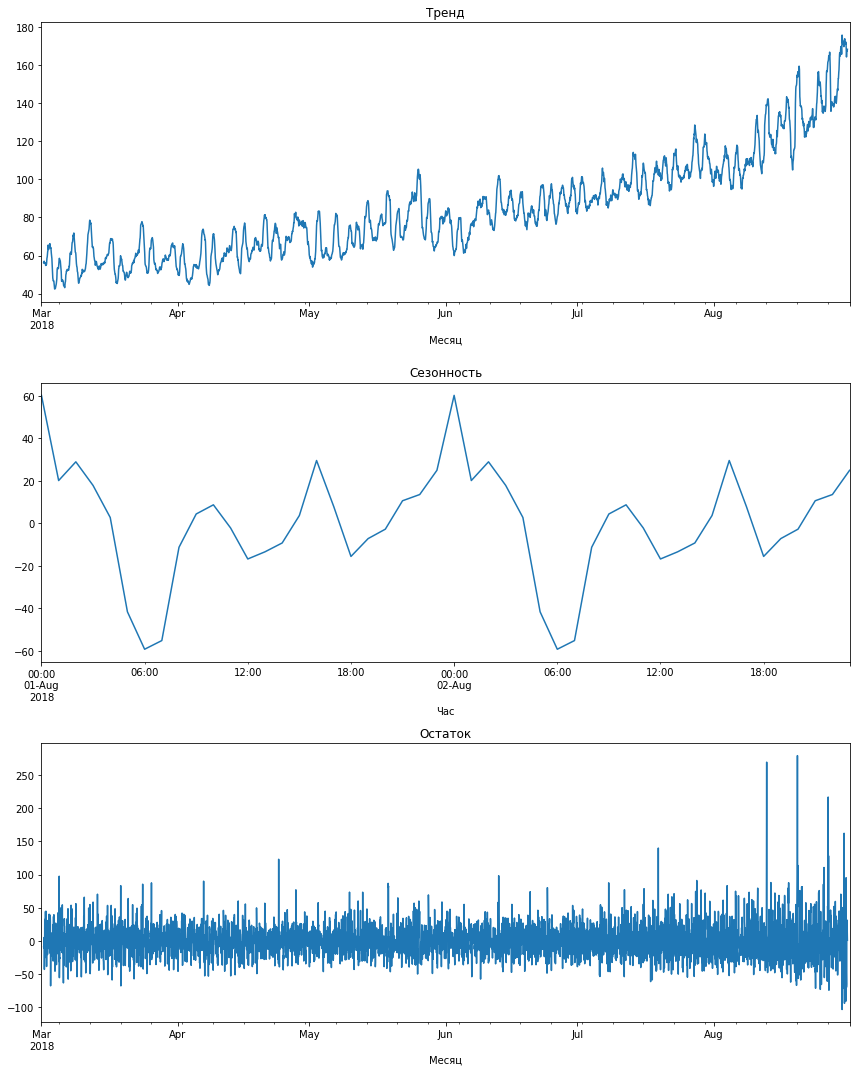

In [84]:
dec = seasonal_decompose(data)

plt.figure(figsize = (12, 15))

plt.subplot(311)
dec.trend.plot()
plt.title('Тренд')
plt.xlabel('Месяц')

plt.subplot(312)
dec.seasonal['2018-08-01':'2018-08-02'].plot()
plt.title('Сезонность')
plt.xlabel('Час')

plt.subplot(313)
dec.resid.plot()
plt.title('Остаток')
plt.xlabel('Месяц')

plt.tight_layout()

### Скользящее среднее

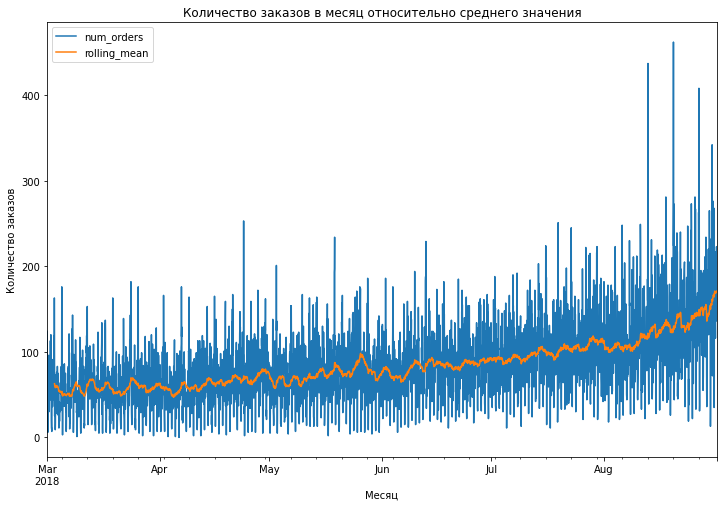

In [85]:
data['rolling_mean'] = data.rolling(50).mean()

data.plot(figsize = (12, 8))
plt.ylabel('Количество заказов')
plt.xlabel('Месяц')
plt.title('Количество заказов в месяц относительно среднего значения');

Заметен плавный рост количества заказов к концу лета, если рассматривать почасовой график, то пик приходится на ночное время. Можно предположить, что этому служит отсутсвие транспорта.

Из графика с скользящим средним можно сказать, что временной рд является нестационарным, т.к. присутствует изменение среднего значения.

## Обучение

Для обучения возьмем модели: CatBoostRegressor, LinearRegressor, LGBMRRegression.

### Подготовка данных

In [86]:
new_data = data.copy()

In [87]:
def make_features(new_data, max_lag, rolling_mean_size):
    new_data['year'] = new_data.index.year
    new_data['month'] = new_data.index.month
    new_data['day'] = new_data.index.day
    new_data['dayofweek'] = new_data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)

    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [88]:
make_features(new_data, 25, 100)
display(new_data.head())

,num_orders,rolling_mean,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,2018,3,1,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,2018,3,1,3,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,2018,3,1,3,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,2018,3,1,3,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,2018,3,1,3,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
new_data = new_data.dropna()
new_data.shape

(4316, 31)

In [90]:
X = new_data.drop('num_orders', axis = 1)
y = new_data['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, test_size = TEST_SIZE)

print(f'Размер обучающей выборки: {X_train.shape} и {y_train.shape}')
print(f'Размер тестовой выборки: {X_test.shape} и {y_test.shape}')

Размер обучающей выборки: (3884, 30) и (3884,)
Размер тестовой выборки: (432, 30) и (432,)


### CatBoostRegressor

In [97]:
%%time

cat_boost = CatBoostRegressor(depth = 10, n_estimators = 25, verbose = 25)

score = cross_val_score(
    cat_boost,
    X_train,
    y_train,
    scoring = 'neg_root_mean_squared_error',
    cv = 5
).mean()

print(f'\n RMSE на тренировочном датасете: {abs(score):.2f}')

Learning rate set to 0.5
0:	learn: 32.0163576	total: 55.2ms	remaining: 1.32s
24:	learn: 12.9567334	total: 1.4s	remaining: 0us
Learning rate set to 0.5
0:	learn: 31.6942367	total: 72.9ms	remaining: 1.75s
24:	learn: 13.0545632	total: 1.43s	remaining: 0us
Learning rate set to 0.5
0:	learn: 31.6211926	total: 53.7ms	remaining: 1.29s
24:	learn: 13.0003887	total: 1.39s	remaining: 0us
Learning rate set to 0.5
0:	learn: 31.5065488	total: 52.7ms	remaining: 1.26s
24:	learn: 13.2700336	total: 1.34s	remaining: 0us
Learning rate set to 0.5
0:	learn: 27.4685817	total: 49.2ms	remaining: 1.18s
24:	learn: 11.7119974	total: 1.15s	remaining: 0us

 RMSE на тренировочном датасете: 26.19
CPU times: user 6.84 s, sys: 35.6 ms, total: 6.87 s
Wall time: 9.17 s


### LinearRegressor

In [100]:
%%time

lr = LinearRegression()

cv = TimeSeriesSplit(n_splits = 5).split(X_train)

score = cross_val_score(
    lr,
    X_train,
    y_train,
    scoring = 'neg_root_mean_squared_error',
    cv = cv
).mean()

print(f'RMSE на тренировочном датасете: {abs(score):.2f}')

RMSE на тренировочном датасете: 27.92
CPU times: user 378 ms, sys: 525 ms, total: 902 ms
Wall time: 895 ms


### LGBMRegressor

In [101]:
%%time

lgbmr = LGBMRegressor(num_leaves= 20, learning_rate=0.01)

score = cross_val_score(
    lgbmr,
    X_train,
    y_train,
    scoring = 'neg_root_mean_squared_error',
    cv = 5
).mean()

print(f'RMSE на тренировочном датасете: {abs(score):.2f}')

RMSE на тренировочном датасете: 29.28
CPU times: user 9.01 s, sys: 85 ms, total: 9.09 s
Wall time: 9.15 s


Лучший результат метрики на тренировочных данных показала модель CatBoostRegression, хоть модель Линейной регрессии и справилась быстрее. Протестируем лучшую модель на тестовой выборке.

## Тестирование

Условие успешного тестирования модели - метрика RMSE не больше 48

Проверка адекватности предсказания с помощью предыдущего значения ряда.

In [102]:
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]
print("RMSE:", mean_squared_error(y_test, pred_previous, squared = False))

RMSE: 59.157061035605636


In [115]:
cat_boost.fit(X_train, y_train)

predict = cat_boost.predict(X_test)
rmse = mean_squared_error(y_test, predict, squared = False)
print(f'RMSE {rmse:.2f}')

Learning rate set to 0.5
0:	learn: 30.7040081	total: 55.6ms	remaining: 1.33s
24:	learn: 14.6614098	total: 1.4s	remaining: 0us
RMSE 44.82


In [135]:
new_data['predict'] = np.around(cat_boost.predict(new_data), 2)
diff = new_data[['num_orders', 'predict', 'rolling_mean']]
diff.head()

,num_orders,predict,rolling_mean
datetime,,,
2018-03-05 04:00:00,34,29.50,56.46
2018-03-05 05:00:00,16,22.60,55.56
2018-03-05 06:00:00,3,10.15,54.87
2018-03-05 07:00:00,14,14.02,54.19
2018-03-05 08:00:00,31,37.87,53.67


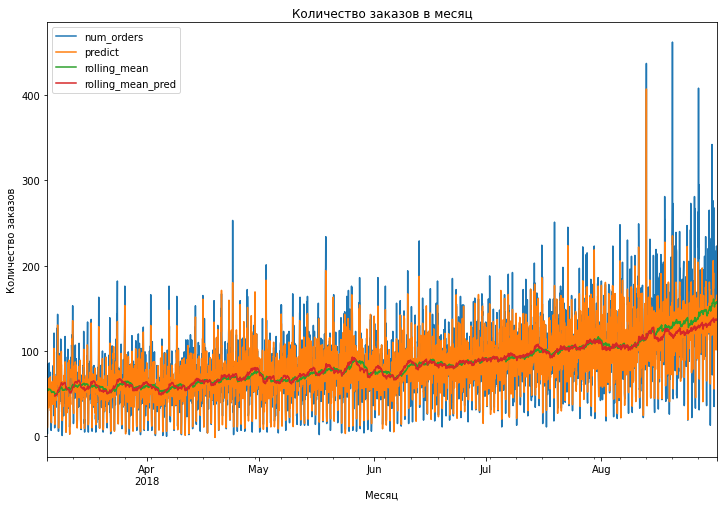

In [137]:
diff['rolling_mean_pred'] = diff['predict'].rolling(50).mean()

diff.plot(figsize = (12, 8))
plt.ylabel('Количество заказов')
plt.xlabel('Месяц')
plt.title('Количество заказов в месяц');

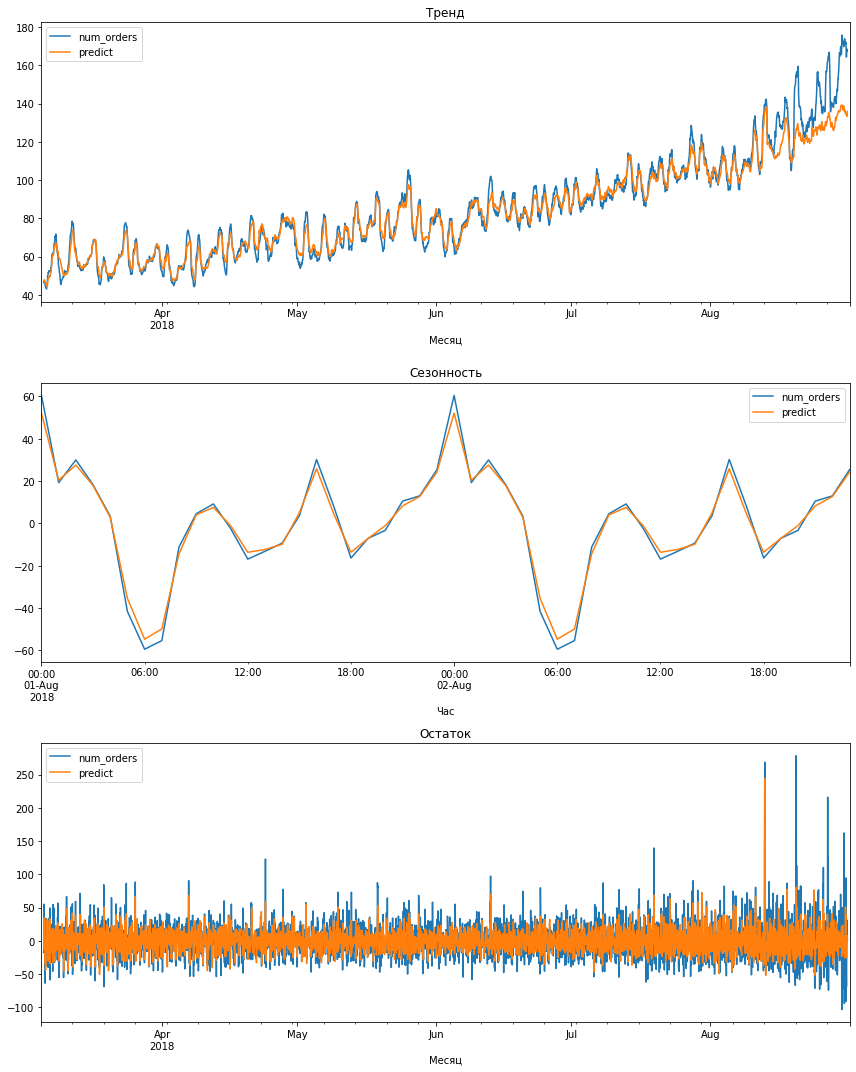

In [128]:
dec1 = seasonal_decompose(diff['num_orders'])
dec = seasonal_decompose(diff['predict'])

plt.figure(figsize = (12, 15))

plt.subplot(311)
dec1.trend.plot(label = 'num_orders')
dec.trend.plot(label = 'predict')
plt.legend()
plt.title('Тренд')
plt.xlabel('Месяц')

plt.subplot(312)
dec1.seasonal['2018-08-01':'2018-08-02'].plot(label = 'num_orders')
dec.seasonal['2018-08-01':'2018-08-02'].plot(label = 'predict')
plt.legend()
plt.title('Сезонность')
plt.xlabel('Час')

plt.subplot(313)
dec1.resid.plot(label = 'num_orders')
dec.resid.plot(label = 'predict')
plt.legend()
plt.title('Остаток')
plt.xlabel('Месяц')

plt.tight_layout()

Модель прошла проверку на адекватность и выполнила условие успешного тестирования. По тренду предказания также показывают рост числа заказов к концу августа, но не такой сильный как на фактических значениях, по сезонности тоже наблюдается увеличение спроса на такси в ночное и вечернее время.

## Вывод

По итогам обучения лучшей показала себя модель CatBoostRegressor, несмотря на то, что линейная модель справилась быстрее. Значение метрики RMSE на тренировочном датасете: 26.19 - показывает, на сколько предказанное значение отличается от истинного, т.е. данная модель ошибается меньше остальных.

Также показатель RMSE на тестовых данных составил 44.82 - модель прошла условие проверки.

По итогу анализа данных и предсказанных значений заметен плавный рост количества заказов к концу лета, если рассматривать почасовой график, то пик приходится на ночное и вечернее время. Можно предположить, что этому служит отсутсвие транспорта.